In [1]:
%load_ext autoreload
%autoreload 2

In [206]:
import time
from copy import deepcopy
import argparse
import sys
import traceback
import json
from tqdm import tqdm_notebook, tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.font_manager import FontProperties
from utils import *


parser = argparse.ArgumentParser()

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

# 1. Prepare Dataset

In [3]:
list_partition = make_partition(args)

# 2. Model Architecture

Create char_to_ix Ref: https://github.com/pytorch/tutorials/blob/master/beginner_source/nlp/word_embeddings_tutorial.py  
Pre-defined Embedding Layer Ref: https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76  
ResNet Variation Ref: https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035

In [4]:
def create_vocab(filename='../Data/logP/vocab.npy'):
    vocab = np.load(filename)
    vocab_size = len(vocab)
    char_to_ix = {char: i for i, char in enumerate(vocab)}
    return vocab, char_to_ix

In [5]:
class ResBlock(nn.Module):
    def __init__(self, in_filter, out_filter, stride, use_bn, dp_rate, block_type):
        super(ResBlock, self).__init__()   
        self.use_bn = use_bn
        self.block_type = block_type
        self.conv1 = nn.Conv2d(in_filter, out_filter, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv2 = nn.Conv2d(out_filter, out_filter, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(out_filter)
        self.bn2 = nn.BatchNorm2d(out_filter)
        self.dropout = nn.Dropout2d(dp_rate)
        self.shortcut = nn.Sequential()
        if in_filter != out_filter:
            self.shortcut.add_module(
                'conv', nn.Conv2d(in_filter, out_filter,
                                  kernel_size=1, stride=stride, 
                                  padding=0, bias=False)
            )
        
    def forward(self, _x):
        if self.block_type == 'a': #original residual block
            x = self.relu(self.bn1(self.conv1(_x))) if self.use_bn else self.relu(self.conv1(_x))
            x = self.bn2(self.conv2(x)) if self.use_bn else self.conv2(x)
            x = x + self.shortcut(_x)
            return self.dropout(self.relu(x))
        
        elif self.block_type == 'b': # BN after addition
            x = self.relu(self.bn1(self.conv1(_x))) if self.use_bn else self.relu(self.conv1(_x))
            x = self.conv2(x) + self.shortcut(_x)
            return self.dropout(self.relu(self.bn2(x)) if self.use_bn else self.relu(x))
        
        elif self.block_type == 'c': # ReLU before addition
            x = self.relu(self.bn1(self.conv1(_x))) if self.use_bn else self.relu(self.conv1(_x))
            x = self.relu(self.bn2(self.conv2(x))) if self.use_bn else self.relu(self.conv2(x))
            return self.dropout(x + self.shortcut(_x))
        
        elif self.block_type == 'd': # ReLU-only pre-activation
            x = self.bn1(self.conv1(self.relu(_x))) if self.use_bn else self.conv1(self.relu(_x))
            x = self.bn2(self.conv2(self.relu(x))) if self.use_bn else self.conv2(self.relu(x))
            return self.dropout(x + self.shortcut(_x))
        
        elif self.block_type == 'e': # full pre-activation
            x = self.conv1(self.relu(self.bn1(_x))) if self.use_bn else self.conv1(self.relu(_x))
            x = self.conv2(self.relu(self.bn2(x))) if self.use_bn else self.conv2(self.relu(x))
            return self.dropout(x + self.shortcut(_x))
             
            

class Net(nn.Module):
    def __init__(self, args):
        super(Net, self).__init__()   
        
        # Create Atom Element embedding layer
        self.embedding = self.create_emb_layer(args.vocab_size, args.emb_train)
        
        # Create Residual Convolution layer
        list_res_blocks = list()
        n_channel = 1
        for i in range(args.n_stage):
            if i==0:
                list_res_blocks.append(ResBlock(n_channel, n_channel*args.start_channel, args.stride, args.use_bn, args.dp_rate, args.block_type))
                n_channel *= args.start_channel
            else:
                list_res_blocks.append(ResBlock(n_channel, n_channel*2, args.stride, args.use_bn, args.dp_rate, args.block_type))
                n_channel *= 2
            for j in range(args.n_layer-1):
                list_res_blocks.append(ResBlock(n_channel, n_channel, 1, args.use_bn, args.dp_rate, args.block_type))
        self.res_blocks = nn.Sequential(*list_res_blocks)
        
        # Create MLP layers
        fc_shape = self._estimate_fc_shape((1, args.max_len,))
#         fc_shape = (4000, 200)
        self.fc1 = nn.Linear(fc_shape[-1], 200)
        self.fc2 = nn.Linear(200, 50)
        self.fc3 = nn.Linear(50, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self._conv_forward(x)
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.squeeze(x)
    
    def _conv_forward(self, x):
        embeds = self.embedding(x)
        embeds = embeds.view(embeds.shape[0], 1, embeds.shape[1], embeds.shape[2])
        x = self.res_blocks(embeds)
        return x
    
    def _estimate_fc_shape(self, input_shape):
        dummy_input = torch.zeros(input_shape).long()
        dummy_output = self._conv_forward(dummy_input)
        fc_shape = dummy_output.view(dummy_output.shape[0], -1).shape
        return fc_shape
        

    def create_emb_layer(self, vocab_size, emb_train):
        emb_layer = nn.Embedding(vocab_size, vocab_size)
        weight_matrix = torch.zeros((vocab_size, vocab_size))
        for i in range(vocab_size):
            weight_matrix[i][i] = 1
        emb_layer.load_state_dict({'weight': weight_matrix})

        if not emb_train:
            emb_layer.weight.requires_grad = False
        return emb_layer

# 3. Train, Validate, Evaluate

In [6]:
def train(model, partition, optimizer, criterion, char_to_ix, args, **kwargs):
    data_iter = DataLoader(
        partition['train'],
        batch_size=args.batch_size,
        shuffle=args.shuffle
    )
    
    epoch_train_loss = 0
    list_train_loss = list()
    cnt_iter = 0
    for batch_idx, batch in enumerate(data_iter):
        X, y = batch[0], batch[1]
        X = torch.Tensor([[char_to_ix[c] for c in smile] for smile in X]).long()
        X, y = X.to(args.device), y.to(args.device).float()
    
        model.train()
        optimizer.zero_grad()

        pred_y = model(X)
        pred_y.require_grad = False
        train_loss = criterion(pred_y, y)
        epoch_train_loss += train_loss.item()
        list_train_loss.append({'epoch':batch_idx/len(data_iter)+kwargs['epoch'], 'train_loss':train_loss.item()})
        train_loss.backward()
        optimizer.step()
        
        cnt_iter += 1
        args.bar.update(len(X))
#         break
    return model, list_train_loss

def validate(model, partition, criterion, char_to_ix, args):
    data_iter = DataLoader(
        partition['val'],
        batch_size=args.test_batch_size,
        shuffle=args.shuffle
    )
    
    epoch_val_loss = 0
    cnt_iter = 0
    for batch_idx, batch in enumerate(data_iter):
        X, y = batch[0], batch[1]
        X = torch.Tensor([[char_to_ix[c] for c in smile] for smile in X]).long()
        X, y = X.to(args.device), y.to(args.device).float()
    
        model.eval()
        pred_y = model(X)
        pred_y.require_grad = False
        val_loss = criterion(pred_y, y)
        epoch_val_loss += val_loss.item()
        cnt_iter += 1

    return epoch_val_loss/cnt_iter

def test(model, partition, char_to_ix, args, **kwargs):
    data_iter = DataLoader(
        partition['test'],
        batch_size=args.test_batch_size,
        shuffle=False
    )
    
    list_y, list_pred_y = list(), list()
    for batch_idx, batch in enumerate(data_iter):
        X, y = batch[0], batch[1]
        X = torch.Tensor([[char_to_ix[c] for c in smile] for smile in X]).long()
        X, y = X.to(args.device), y.to(args.device).float()
    
        model.eval()
        pred_y = model(X)
        list_y += y.cpu().detach().numpy().tolist()
        list_pred_y += pred_y.cpu().detach().numpy().tolist()
        args.bar.update(len(X))

    mae = mean_absolute_error(list_y, list_pred_y)
    std = np.std(np.array(list_y)-np.array(list_pred_y))
    return mae, std, list_y, list_pred_y

def experiment(partition, args):
    ts = time.time()
    vocab, char_to_ix = create_vocab()
    args.vocab_size = len(vocab)
    args.input_shape = (args.max_len, args.vocab_size)
    model = Net(args)
    model.to(args.device)
    criterion = nn.MSELoss()
    
    # Initialize Optimizer
    trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
    if args.optim == 'ADAM':
        optimizer = optim.Adam(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'RMSProp':
        optimizer = optim.RMSprop(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(trainable_parameters, lr=args.lr, weight_decay=args.l2_coef)
    else:
        assert False, "Undefined Optimizer Type"
        
    # Train, Validate, Evaluate
    list_train_loss = list()
    list_val_loss = list()
    list_mae = list()
    list_std = list()
    
    args.best_mae = 10000
    for epoch in range(args.epoch):
        model, train_losses = train(model, partition, optimizer, criterion, char_to_ix, args, **{'bar':bar, 'epoch':epoch})
        val_loss = validate(model, partition, criterion, char_to_ix, args)
        mae, std, true_y, pred_y = test(model, partition, char_to_ix, args, **{'bar':bar, 'epoch':epoch})

        list_train_loss += train_losses
        list_val_loss.append({'epoch':epoch, 'val_loss':val_loss})
        list_mae.append({'epoch':epoch, 'mae':mae})
        list_std.append({'epoch':epoch, 'std':std})
        
        if args.best_mae > mae or epoch==0:
            args.best_epoch = epoch
            args.best_mae = mae
            args.best_std = std
            args.best_true_y = true_y
            args.best_pred_y = pred_y
    
    te = time.time()
    
    # Logging Experiment Results
    args.elapsed = te-ts
    args.train_losses = list_train_loss
    args.val_losses = list_val_loss
    args.maes = list_mae
    args.stds = list_std
    return args

# 4. Visualization

In [216]:
from decimal import Decimal

def generate_setting(args, var1, var2):
    dict_args = vars(args)
    output = '{:92}'.format('[Exp Settings]') + '\n'
    output += '-'*91 + '\n'

    num_var = 3
    cnt_var = 0
    for keyword, value in dict_args.items():
        if keyword != var1 and keyword != var2 and type(value) != list and not 'best' in keyword and keyword != 'elapsed':
            str_value = str(value)
            if str_value.isdigit():
                if type(value) == float:
                    temp = '| {}={:.2E}'.format(keyword, Decimal(dict_args[keyword]))
                if type(value) == int:
                    temp = '| {}={}'.format(keyword, str_value[:15])

            else:
                temp = '| {}={}'.format(keyword, str_value[:15])
            output += '{:<30}'.format(temp[:30])
            cnt_var += 1
            if cnt_var % num_var == 0:
                cnt_var = 0
                output += '|\n'
                output += '-'*91 + '\n'
    return output

In [201]:
def plot_performance(results, variable1, variable2, title='', filename=''):
    fig, ax = plt.subplots(1, 2)

    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    sns.barplot(x=variable1, y='best_mae', hue=variable2, data=results, ax=ax[0])
    sns.barplot(x=variable1, y='best_std', hue=variable2, data=results, ax=ax[1])

    font = FontProperties()
    font.set_family('monospace')
    font.set_size('large')
    alignment = {'horizontalalignment': 'center', 'verticalalignment': 'baseline'}
    fig.text(0.5, -0.6, generate_setting(args, variable1, variable2), fontproperties=font, **alignment)
    
    fig.suptitle(title)
    filename = filename if len(filename) > 0 else title
    plt.savefig('./images/{}.png'.format(filename))


In [218]:
def plot_distribution(results, variable1, variable2, x='true_y', y='pred_y', title='', filename='', **kwargs):
    list_v1 = results[variable1].unique()
    list_v2 = results[variable2].unique()
    list_data = list()
    for value1 in list_v1:
        for value2 in list_v2:
            row = results.loc[results[variable1]==value1]
            row = row.loc[results[variable2]==value2]

            best_true_y = list(row.best_true_y)[0]
            best_pred_y = list(row.best_pred_y)[0]
            for i in range(len(best_true_y)):
                list_data.append({x:best_true_y[i], y:best_pred_y[i], variable1:value1, variable2:value2})
    df = pd.DataFrame(list_data)

    g = sns.FacetGrid(df, row=variable2, col=variable1, margin_titles=True)
    g.map(plt.scatter, x, y, alpha=0.3)

    def identity(**kwargs):
        plt.plot(np.linspace(-4,4,50), np.linspace(-4,4,50),'k',linestyle='dashed')
    g.map(identity)
    g.set_axis_labels(x, y)
    g.fig.suptitle(title) # can also get the figure from plt.gcf()
    plt.subplots_adjust(top=kwargs.get('top',0.93))
    filename = filename if len(filename) > 0 else title
    plt.savefig('./images/{}.png'.format(filename))


In [220]:
def plot_loss(results, variable1, variable2, x='true_y', y='pred_y', title='', filename='', **kwargs):
    list_v1 = results[variable1].unique()
    list_v2 = results[variable2].unique()
    list_data = list()
    for value1 in list_v1:
        for value2 in list_v2:
            row = results.loc[results[variable1]==value1]
            row = row.loc[results[variable2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]
            maes = list(row.maes)[0]
            
            for item in train_losses:
                item.update({'type':'train', 'loss':item['train_loss'], variable1:value1, variable2:value2})
                
            for item in val_losses:
                item.update({'type':'val', 'loss':item['val_loss'], variable1:value1, variable2:value2})
            
            for item in maes:
                item.update({'type':'mae', variable1:value1, variable2:value2})
            list_data += train_losses + val_losses + maes

    df = pd.DataFrame(list_data)
    ymax = df['mae'].max()
    ymin = df['mae'].min()

    g = sns.FacetGrid(df, row=variable2, col=variable1, hue='type', margin_titles=False)
    axes = g.axes
    for i in range(len(axes)):
        for j in range(len(axes[0])):
            if i==0:
                g.axes[i][j].yaxis.set_label_coords(1.1,0.9)
                
    def mae_line(x, y, **kwargs):
        ax2 = plt.gca().twinx()
        ax2.plot(x, y,'g--')
        ax2.set_ylim(kwargs['ymax']*1.05, kwargs['ymin']*0.95)
        ax2.grid(False)

    g.map(plt.plot, x, y)
    g.map(mae_line, 'epoch', 'mae', ymin=ymin, ymax=ymax)
    g.set_axis_labels(x, y)
    g.fig.suptitle(title) # can also get the figure from plt.gcf()
    g.add_legend()
    
    plt.subplots_adjust(top=kwargs.get('top',0.93))
    filename = filename if len(filename) > 0 else title
    plt.savefig('./images/{}.png'.format(filename))

# Experiment.1  n_stage vs n_layer

In [210]:
exp_name = 'exp1_layer_stage'
args = parser.parse_args("")
args.exp_name = exp_name
args.n_layer = 2
args.n_stage = 1
args.lr = 0.00005
args.l2_coef = 0.0001
args.optim = 'ADAM'
args.epoch = 50
args.batch_size= 256
args.test_batch_size= 256
args.emb_train = False
args.start_channel = 8
args.stride = 2
args.use_bn = True
args.dp_rate = 0.3
args.block_type = 'a'
args.max_len= 120
args.shuffle = True
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
writer = Writer(prior_keyword=['n_layer', 'n_stage','block_type', 'use_bn', 'dp_rate', 'emb_train', 'epoch', 'batch_size'])
partition = list_partition[0]

# Define Hyperparameter Search Space
list_n_layer = [1,2,3,4]
list_n_stage = [1,2,3,4]

# Initialize num iteration, num experiment, progress bar
n_iter = args.epoch * (len(partition['train']) + len(partition['test']))
n_exp = len(list_n_layer)*len(list_n_stage)
cnt_exp = 0
bar = tqdm_notebook(total=n_exp*n_iter, file=sys.stdout, position=0)
bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))

# writer.clear(exp_name)
for n_layer in list_n_layer:
    for n_stage in list_n_stage:
        # Update hyperparameter
        args.n_layer = n_layer
        args.n_stage = n_stage
        args.bar = bar
        result = experiment(partition, args)
        writer.write(result)
        torch.cuda.empty_cache()

        cnt_exp += 1
        bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))
        print('[Exp {:2}] got mae: {:2.3f}, std: {:2.3f} at epoch {:2}'.format(cnt_exp, result.best_mae, result.best_std, result.epoch))


[Exp  1] got mae: 0.403, std: 0.509 at epoch 50
[Exp  2] got mae: 0.477, std: 0.584 at epoch 50
[Exp  3] got mae: 0.378, std: 0.438 at epoch 50
[Exp  4] got mae: 0.319, std: 0.388 at epoch 50
[Exp  5] got mae: 0.581, std: 0.679 at epoch 50
[Exp  6] got mae: 0.504, std: 0.577 at epoch 50
[Exp  7] got mae: 0.437, std: 0.495 at epoch 50
[Exp  8] got mae: 0.360, std: 0.450 at epoch 50
[Exp  9] got mae: 0.659, std: 0.737 at epoch 50
[Exp 10] got mae: 0.476, std: 0.550 at epoch 50
[Exp 11] got mae: 0.448, std: 0.549 at epoch 50
[Exp 12] got mae: 0.383, std: 0.485 at epoch 50
[Exp 13] got mae: 0.637, std: 0.687 at epoch 50
[Exp 14] got mae: 0.581, std: 0.642 at epoch 50
[Exp 15] got mae: 0.446, std: 0.518 at epoch 50
[Exp 16] got mae: 0.475, std: 0.604 at epoch 50


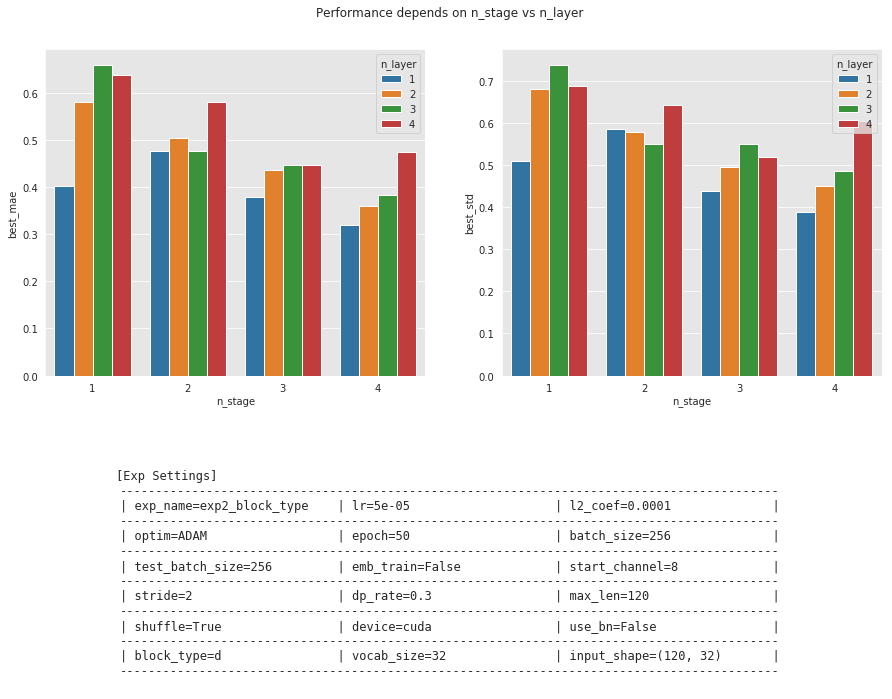

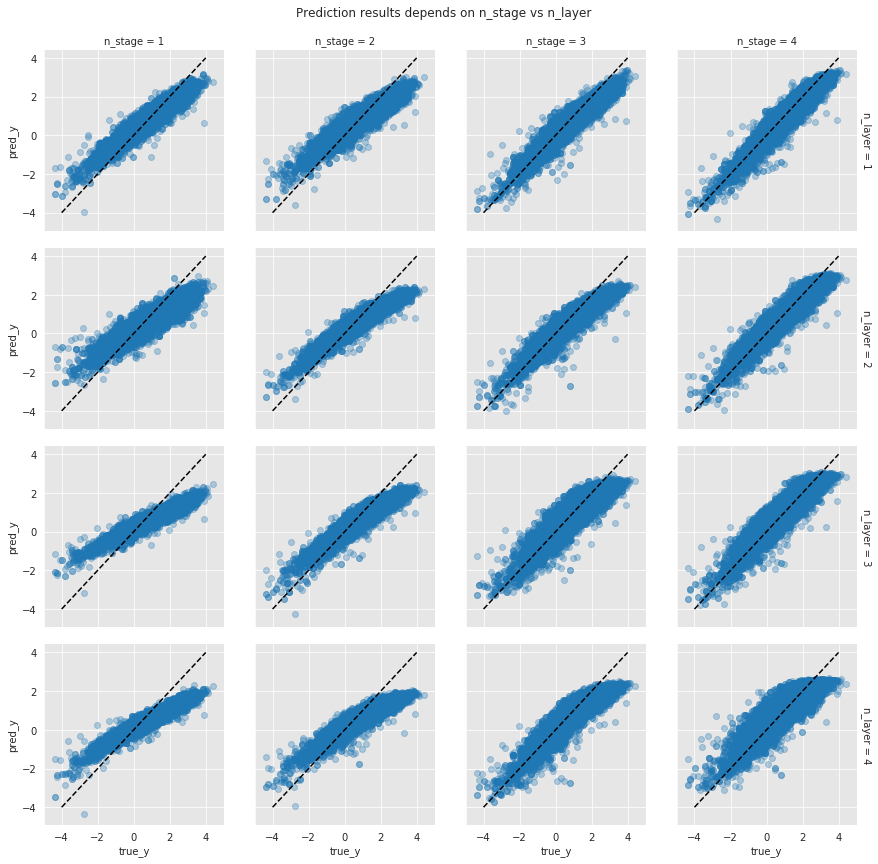

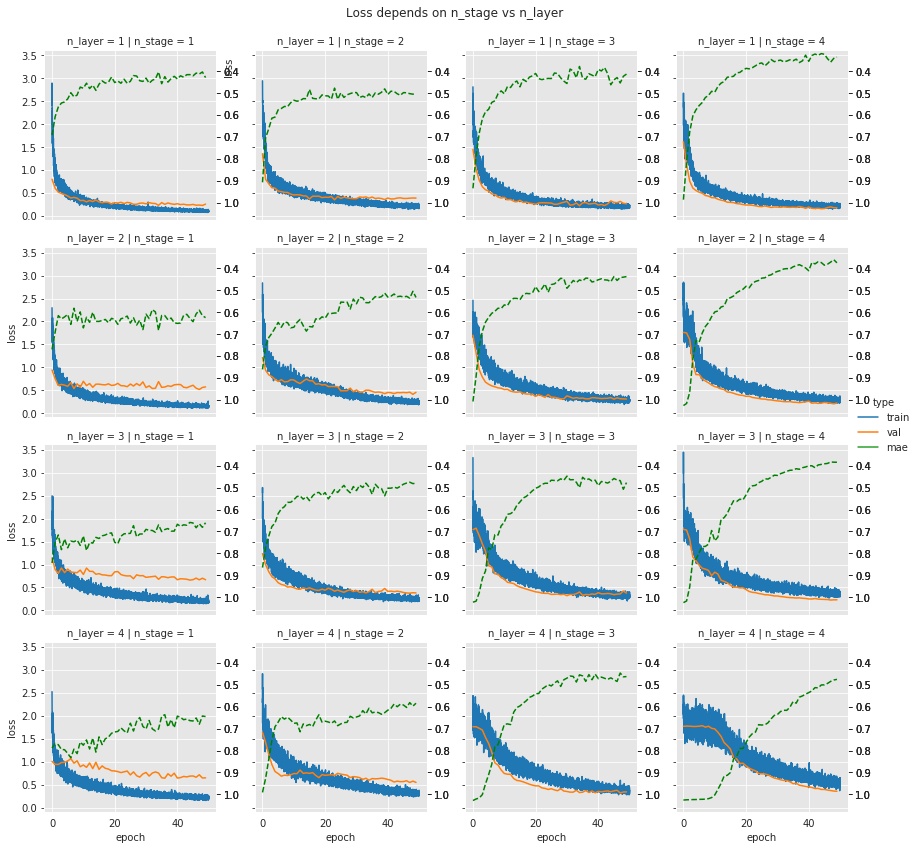

In [222]:
results = writer.read(exp_name='exp1_layer_stage')
results = results.loc[results['epoch']==50]
variable1 = 'n_stage'
variable2 = 'n_layer'


plot_performance(results, variable1, variable2,
                'Performance depends on {} vs {}'.format(variable1, variable2),
                'exp1_Performance {} vs {}'.format(variable1, variable2))

plot_distribution(results, variable1, variable2, 'true_y', 'pred_y', 
                  'Prediction results depends on {} vs {}'.format(variable1, variable2),
                  'exp1_Prediction {} vs {}'.format(variable1, variable2))

plot_loss(results, variable1, variable2, 'epoch', 'loss', 
                  'Loss depends on {} vs {}'.format(variable1, variable2),
                  'exp1_Loss {} vs {}'.format(variable1, variable2))

plt.show()


# Experiment.1 n_stage vs n_layer  

In this experiment, regression performance was measured by 'mae' metric among the variation of the number of the residual block(n_stage) and the number of the layer per block(n_layer).  

**Variable Domain**  
- n_stage = [1, 2, 3, 4]  
- n_layer = [1, 2, 3, 4]

# Results and Discussion

1. The first figure shows the mae and std variation depends on the number of residual block and number of convolution layer in the residual block. Also, it notify the experiment settings.  
2. The second figure shows the distribution between ground truth y and predicted y with y=x line(dashed).  
3. The last figure shows the train loss, validation loss(left y-axis) and mae score (right y-axis).  

**Notable Results**  
- As the number of the residual block increased, overall performance was increased.  
- As the number of the layer in a residual block increased, overall performance was decreased.  
- Therefore, 4 block with 1 layer per block achieved highest performance. 

**Discussion**  
- I expected that 4 block with 4 layer per block would outperform other models, however it was not. This results should be reconsidered since the loss chart of 4 block with 4 layer per block shows that the validation loss is still lower than the train loss. Therefore, longer training should be conducted. 
- As expected, the models with less residual block shows poor prediction performance. 

# Experiment.2 Block Type vs Batch Normalization

In [211]:
exp_name = 'exp2_block_type_batch_norm'
args = parser.parse_args("")
args.exp_name = exp_name
args.n_layer = 1
args.n_stage = 4
args.lr = 0.00005
args.l2_coef = 0.0001
args.optim = 'ADAM'
args.epoch = 50
args.batch_size= 256
args.test_batch_size= 256
args.emb_train = False
args.start_channel = 8
args.stride = 2
args.dp_rate = 0.3
args.max_len= 120
args.shuffle = True
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
writer = Writer(prior_keyword=['n_layer', 'n_stage','block_type', 'use_bn', 'dp_rate', 'emb_train', 'epoch', 'batch_size'])
partition = list_partition[0]

# Define Hyperparameter Search Space
list_use_bn = [True, False]
list_block_type = ['a', 'b', 'c', 'd']


# Initialize num iteration, num experiment, progress bar
n_iter = args.epoch * (len(partition['train']) + len(partition['test']))
n_exp = len(list_use_bn)*len(list_block_type)
cnt_exp = 0
bar = tqdm_notebook(total=n_exp*n_iter, file=sys.stdout, position=0)
bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))

# writer.clear(exp_name)
for use_bn in list_use_bn:
    for block_type in list_block_type:
        # Update hyperparameter
        args.use_bn = use_bn
        args.block_type = block_type
        args.bar = bar
        result = experiment(partition, args)
        writer.write(result)
        torch.cuda.empty_cache()

        cnt_exp += 1
        bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))
        print('[Exp {:2}] got mae: {:2.3f}, std: {:2.3f} at epoch {:2}'.format(cnt_exp, result.best_mae, result.best_std, result.epoch))


[Exp  1] got mae: 0.298, std: 0.385 at epoch 50
[Exp  2] got mae: 0.313, std: 0.399 at epoch 50
[Exp  3] got mae: 0.308, std: 0.393 at epoch 50
[Exp  4] got mae: 0.330, std: 0.423 at epoch 50
[Exp  5] got mae: 0.610, std: 0.652 at epoch 50
[Exp  6] got mae: 0.590, std: 0.697 at epoch 50
[Exp  7] got mae: 0.675, std: 0.756 at epoch 50
[Exp  8] got mae: 0.587, std: 0.677 at epoch 50


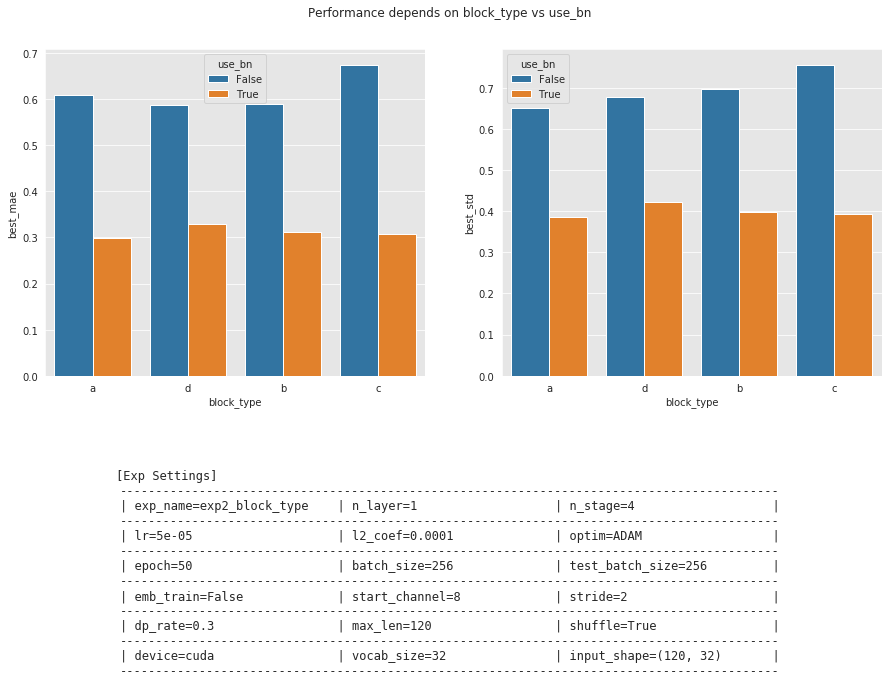

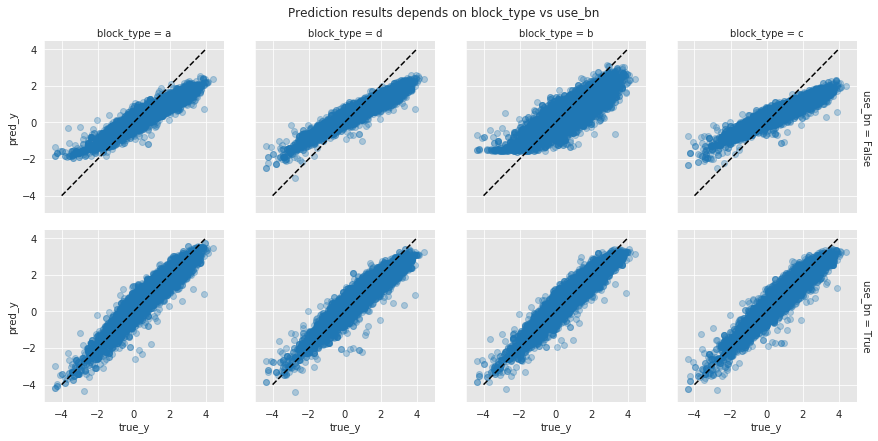

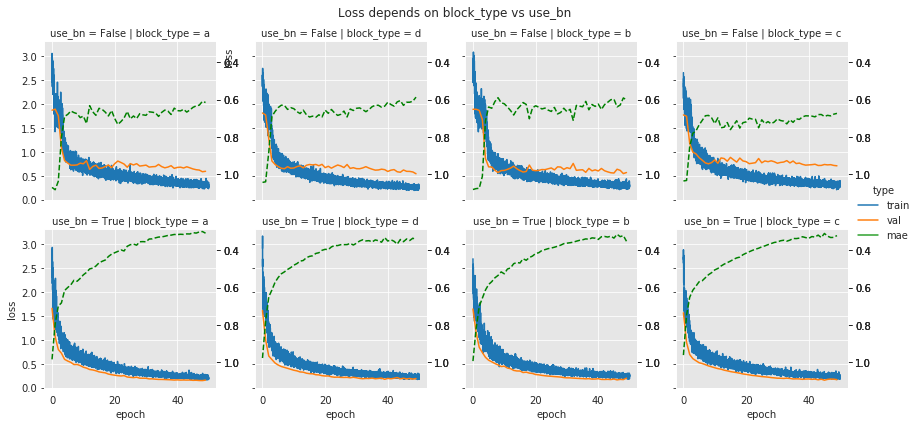

In [224]:
results = writer.read(exp_name='exp2_block_type_batch_norm')
results = results.loc[results['epoch']==50]

variable1 = 'block_type'
variable2 = 'use_bn'


plot_performance(results, variable1, variable2,
                'Performance depends on {} vs {}'.format(variable1, variable2),
                'exp1_Performance {} vs {}'.format(variable1, variable2))

plot_distribution(results, variable1, variable2, 'true_y', 'pred_y', 
                  'Prediction results depends on {} vs {}'.format(variable1, variable2),
                  'exp1_Prediction {} vs {}'.format(variable1, variable2), top=0.9)

plot_loss(results, variable1, variable2, 'epoch', 'loss', 
                  'Loss depends on {} vs {}'.format(variable1, variable2),
                  'exp1_Loss {} vs {}'.format(variable1, variable2), top=0.9)

plt.show()


# Experiment.2 Block Type vs Batch Normalization

In this experiment, regression performance was measured by 'mae' metric among the variation of the type of the residual block(block_type) and the usage of the batch normalization layer in each residual block(use_bn).     

**Variable Domain**  
- block_type = ['a':'original, 'b':BN after addition, 'c':ReLU before addition, 'd':ReLU-only pre-activation]  
- use_bn = [True, False]

# Results and Discussion

1. The first figure shows the mae and std variation depends on the residual block type and the usage of the batch normalization layer. Also, it notify the experiment settings.  
2. The second figure shows the distribution between ground truth y and predicted y with y=x line(dashed).  
3. The last figure shows the train loss, validation loss(left y-axis) and mae score (right y-axis).  

**Notable Results**  
- Among 4 types of residual block, block A and C types are outperformed.
- When the batch normalization layer is used, the mae was almost reduced as half. 
- Also, when the batch normalization is applied, the mae values recorded less variation among different block types.

**Discussion**  
- The batch normalization layer boosts up the performance more than I expected. (very powerful).  
- Different residual block has less significant impact on the results.  

# Experiment.3 Trainable Embedding vs Start Channel

In [229]:
exp_name = 'exp3_emb_train_start_channel'
args = parser.parse_args("")
args.exp_name = exp_name
args.n_layer = 1
args.n_stage = 4
args.lr = 0.00005
args.l2_coef = 0.0001
args.optim = 'ADAM'
args.epoch = 50
args.batch_size= 256
args.test_batch_size= 256
args.start_channel = 8
args.stride = 2
args.dp_rate = 0.3
args.max_len= 120
args.shuffle = True
args.use_bn = True
args.block_type = 'a'
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
writer = Writer(prior_keyword=['n_layer', 'n_stage','block_type', 'use_bn', 'dp_rate', 'emb_train', 'epoch', 'start_channel'])
partition = list_partition[0]

# Define Hyperparameter Search Space
list_emb_train = [True, False]
list_start_channel = [4,8,16,32]


# Initialize num iteration, num experiment, progress bar
n_iter = args.epoch * (len(partition['train']) + len(partition['test']))
n_exp = len(list_emb_train)*len(list_start_channel)
cnt_exp = 0
bar = tqdm_notebook(total=n_exp*n_iter, file=sys.stdout, position=0)
bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))

# writer.clear(exp_name)
for emb_train in list_emb_train:
    for start_channel in list_start_channel:
        # Update hyperparameter
        args.emb_train = emb_train
        args.start_channel = start_channel
        args.bar = bar
        
        ts = time.time()
        result = experiment(partition, args)
        writer.write(result)
        torch.cuda.empty_cache()
        te = time.time()
        
        cnt_exp += 1
        bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))
        print('[Exp {:2}] got mae: {:2.3f}, std: {:2.3f} at epoch {:2} Took {:3.1f}'.format(cnt_exp, result.best_mae, result.best_std, result.epoch, te-ts))


[Exp  1] got mae: 0.407, std: 0.466 at epoch 50 Took 151.9
[Exp  2] got mae: 0.256, std: 0.334 at epoch 50 Took 161.7
[Exp  3] got mae: 0.193, std: 0.253 at epoch 50 Took 195.4
[Exp  4] got mae: 0.166, std: 0.224 at epoch 50 Took 315.6
[Exp  5] got mae: 0.541, std: 0.604 at epoch 50 Took 92.1
[Exp  6] got mae: 0.327, std: 0.404 at epoch 50 Took 93.2
[Exp  7] got mae: 0.226, std: 0.295 at epoch 50 Took 107.3
[Exp  8] got mae: 0.178, std: 0.239 at epoch 50 Took 225.2


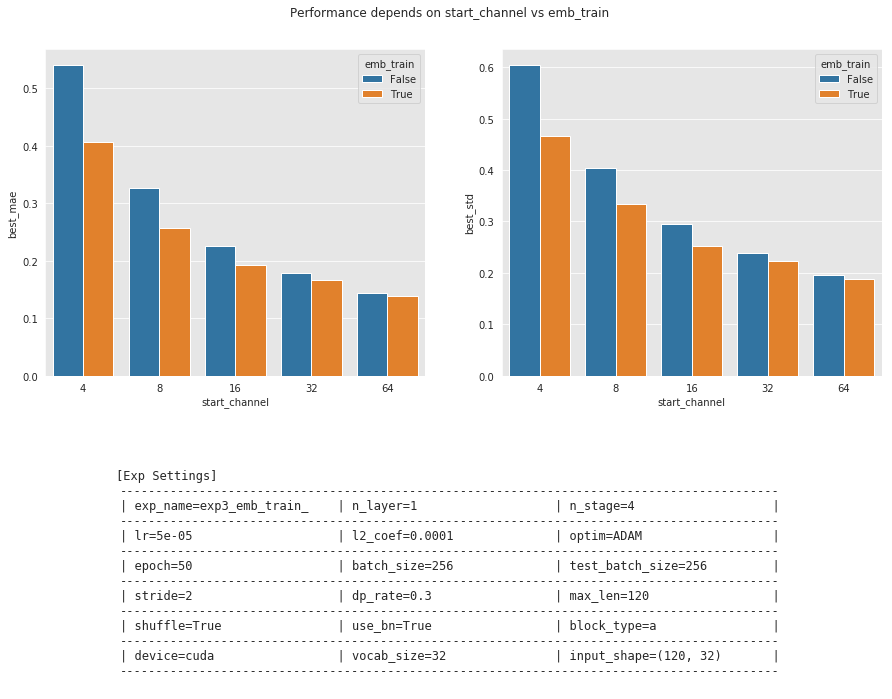

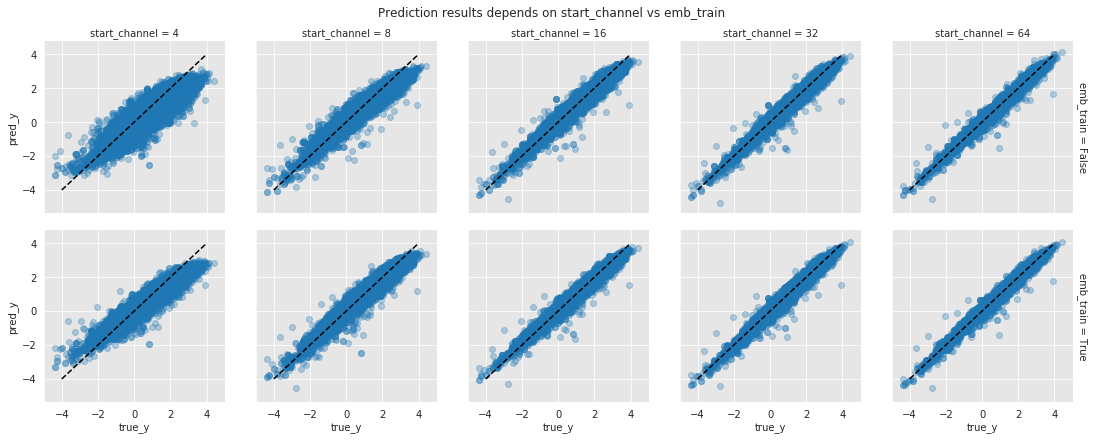

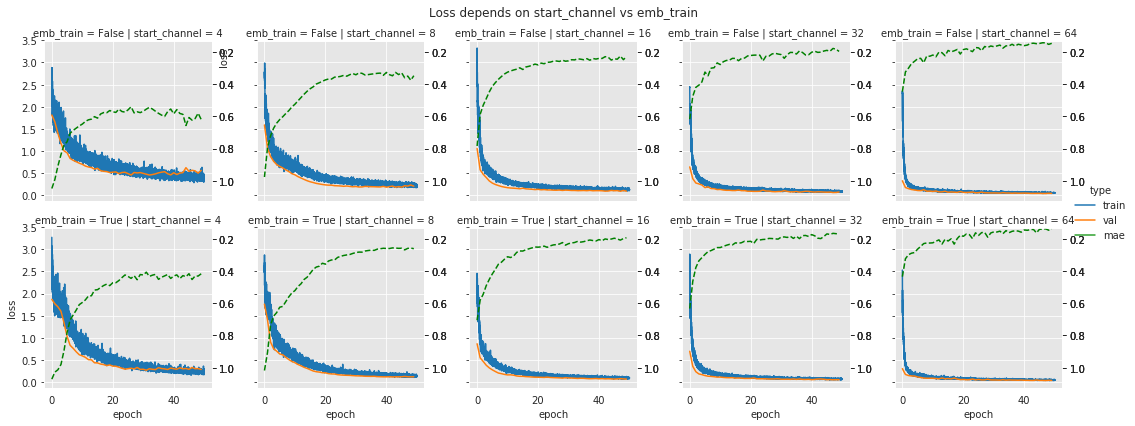

In [230]:
results = writer.read(exp_name='exp3_emb_train_start_channel')
# results = results.loc[results['epoch']==50]

variable1 = 'start_channel'
variable2 = 'emb_train'


plot_performance(results, variable1, variable2,
                'Performance depends on {} vs {}'.format(variable1, variable2),
                'exp1_Performance {} vs {}'.format(variable1, variable2))

plot_distribution(results, variable1, variable2, 'true_y', 'pred_y', 
                  'Prediction results depends on {} vs {}'.format(variable1, variable2),
                  'exp1_Prediction {} vs {}'.format(variable1, variable2), top=0.9)

plot_loss(results, variable1, variable2, 'epoch', 'loss', 
                  'Loss depends on {} vs {}'.format(variable1, variable2),
                  'exp1_Loss {} vs {}'.format(variable1, variable2), top=0.9)

plt.show()


# Experiment.3 Trainable Embedding vs Start Channel

In this experiment, regression performance was measured by 'mae' metric among the number of the starting convolution filters(start_channel) and the usage of trainable atom embedding(emb_train).  

**Variable Domain**  
- emb_train = [True, False]
- start_channel = [4,8,16,32,64]

# Results and Discussion

1. The first figure shows the mae and std variation depends on the number of convolution channel of the first residual block(start_channel) and the trainability of the atom embedding vector(emb_train). Also, it notify the experiment settings.  
2. The second figure shows the distribution between ground truth y and predicted y with y=x line(dashed).  
3. The last figure shows the train loss, validation loss(left y-axis) and mae score (right y-axis).  

**Notable Results**  
- As the number of the start channel increased, the performance drastically improved. 
- When the embedding vectors were trained, the performance was slightly increased. 

**Discussion**  
- Increasing the number of the convolution filter results in the increasing performance. However lots of computation power required.     
- Training original embedding vector is meaningful to increase the performance. 

In [234]:
exp_name = 'exp4_lr_l2'
args = parser.parse_args("")
args.exp_name = exp_name
args.n_layer = 1
args.n_stage = 4
args.emb_train = True
args.optim = 'ADAM'
args.epoch = 50
args.batch_size= 512
args.test_batch_size= 512
args.start_channel = 16
args.stride = 2
args.dp_rate = 0.3
args.max_len= 120
args.shuffle = True
args.use_bn = True
args.block_type = 'a'
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
writer = Writer(prior_keyword=['lr', 'l2_coef', 'n_layer', 'n_stage','block_type', 'use_bn', 'dp_rate', 'emb_train', 'epoch', 'start_channel'])
partition = list_partition[0]

# Define Hyperparameter Search Space
list_lr = [0.00005, 0.0005, 0.005, 0.05]
list_l2_coef = [0.0001, 0.001, 0.01, 0.1]

# Initialize num iteration, num experiment, progress bar
n_iter = args.epoch * (len(partition['train']) + len(partition['test']))
n_exp = len(list_lr)*len(list_l2_coef)
cnt_exp = 0
bar = tqdm_notebook(total=n_exp*n_iter, file=sys.stdout, position=0)
bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))

# writer.clear(exp_name)
for lr in list_lr:
    for l2_coef in list_l2_coef:
        # Update hyperparameter
        args.lr = lr
        args.l2_coef = l2_coef
        args.bar = bar
        
        ts = time.time()
        result = experiment(partition, args)
        writer.write(result)
        torch.cuda.empty_cache()
        te = time.time()
        
        cnt_exp += 1
        bar.set_description('P {:2}/{} Exp'.format(cnt_exp, n_exp))
        print('[Exp {:2}] got mae: {:2.3f}, std: {:2.3f} at epoch {:2} Took {:3.1f}sec'.format(cnt_exp, result.best_mae, result.best_std, result.epoch, te-ts))


[Exp  1] got mae: 0.217, std: 0.287 at epoch 50 Took 188.5sec
[Exp  2] got mae: 0.220, std: 0.286 at epoch 50 Took 188.2sec
[Exp  3] got mae: 0.222, std: 0.287 at epoch 50 Took 188.1sec
[Exp  4] got mae: 0.237, std: 0.286 at epoch 50 Took 189.1sec
[Exp  5] got mae: 0.134, std: 0.184 at epoch 50 Took 189.0sec
[Exp  6] got mae: 0.129, std: 0.177 at epoch 50 Took 189.0sec
[Exp  7] got mae: 0.146, std: 0.193 at epoch 50 Took 188.8sec
[Exp  8] got mae: 0.153, std: 0.201 at epoch 50 Took 189.0sec
[Exp  9] got mae: 0.142, std: 0.186 at epoch 50 Took 188.5sec
[Exp 10] got mae: 0.145, std: 0.189 at epoch 50 Took 188.9sec
[Exp 11] got mae: 0.162, std: 0.213 at epoch 50 Took 188.7sec
[Exp 12] got mae: 0.220, std: 0.286 at epoch 50 Took 188.3sec
[Exp 13] got mae: 0.327, std: 0.420 at epoch 50 Took 188.4sec
[Exp 14] got mae: 0.347, std: 0.445 at epoch 50 Took 188.7sec
[Exp 15] got mae: 0.471, std: 0.600 at epoch 50 Took 188.8sec
[Exp 16] got mae: 0.341, std: 0.426 at epoch 50 Took 188.6sec


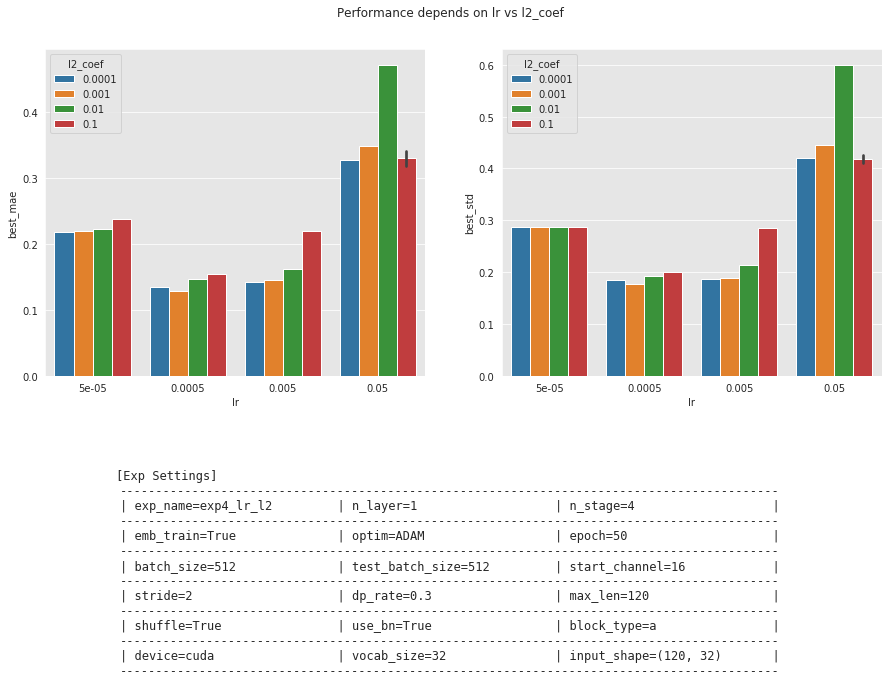

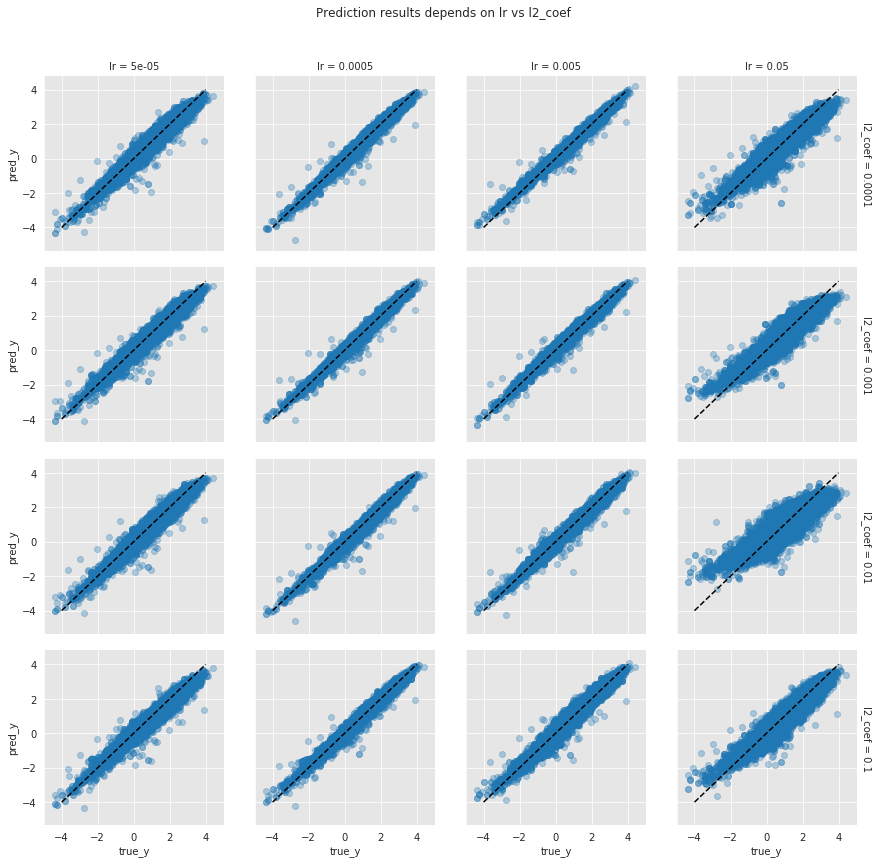

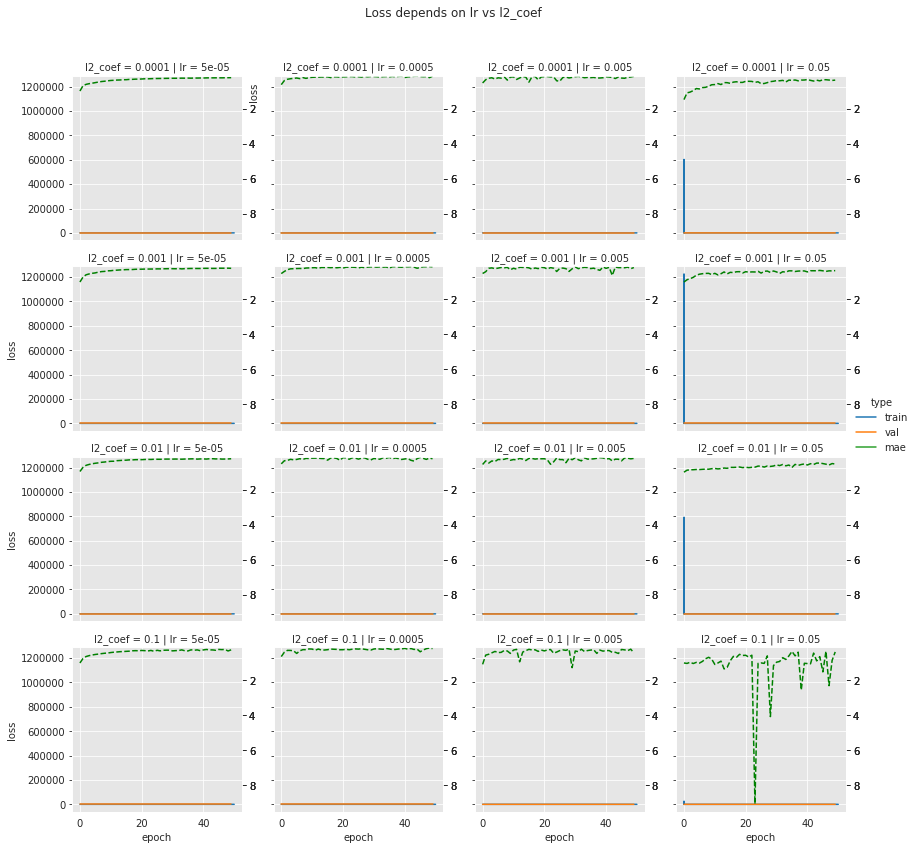

In [236]:
results = writer.read(exp_name='exp4_lr_l2')
# results = results.loc[results['epoch']==50]

variable1 = 'lr'
variable2 = 'l2_coef'


plot_performance(results, variable1, variable2,
                'Performance depends on {} vs {}'.format(variable1, variable2),
                'exp1_Performance {} vs {}'.format(variable1, variable2))

plot_distribution(results, variable1, variable2, 'true_y', 'pred_y', 
                  'Prediction results depends on {} vs {}'.format(variable1, variable2),
                  'exp1_Prediction {} vs {}'.format(variable1, variable2), top=0.9)

plot_loss(results, variable1, variable2, 'epoch', 'loss', 
                  'Loss depends on {} vs {}'.format(variable1, variable2),
                  'exp1_Loss {} vs {}'.format(variable1, variable2), top=0.9)

plt.show()
